In [1]:
data_file = './kddcup.data_10_percent.gz'
raw_data = sc.textFile(data_file)

本地向量通常用作Spark MLlib中RDD的基本类型。 局部向量具有整数类型和基于0的索引和双类型值，存储在单个机器上。 MLlib支持两种类型的局部向量：密集和稀疏。 密集向量由表示其条目值的双数组支持，而稀疏向量由两个并行数组支持：索引和值。

对于密集向量，MLlib使用Python列表或NumPy数组类型。 推荐使用后者，因此您可以简单地传递NumPy数组。

对于稀疏向量，用户可以从MLlib构造SparseVector对象，或者如果SciPy在其环境中可用，则传递SciPy scipy.sparse列向量。 创建稀疏向量的最简单方法是使用Vector中实现的工厂方法。

### An RDD of dense vectors
Let's represent each network interaction in our dataset as a dense vector. For that we will use the NumPy array type.

In [2]:
import numpy as np

def parse_interaction(line):
    line_split = line.split(',')
    # keep just numberic and logical values
    symbolic_indexes = [1,2,3,41]
    clean_line_split = [item for i,item in enumerate(line_split) if i not in symbolic_indexes]
    return np.array([float(x) for x in clean_line_split])

vector_data = raw_data.map(parse_interaction)

### Summary statistics
Spark's MLlib provides column summary statistics for RDD[Vector] through the function colStats available in Statistics. The method returns an instance of MultivariateStatisticalSummary, which contains the column-wise max, min, mean, variance, and number of nonzeros, as well as the total count.

In [3]:
# spark 的统计函数 ，按列（column）来统计
from pyspark.mllib.stat import Statistics
from math import sqrt

# compute column summary statistics.
summary = Statistics.colStats(vector_data)

print("Duration Statistics:")
print(" Mean: {}".format(round(summary.mean()[0],3)))
print(" St. deviation: {}".format(round(sqrt(summary.variance()[0]),3)))
print(" Max value: {}".format(round(summary.max()[0],3)))
print(" Min value: {}".format(round(summary.min()[0],3)))
print(" Total value count: {}".format(summary.count()))
print(" Number of non-zero values: {}".format(summary.numNonzeros()[0]))

Duration Statistics:
 Mean: 47.979
 St. deviation: 707.746
 Max value: 58329.0
 Min value: 0.0
 Total value count: 494021
 Number of non-zero values: 12350.0


### Summary statistics by label
通过按 键 来进行统计

In [6]:
def parse_interaction_with_key(line):
    line_split = line.split(",")
    # keep just numeric and logical values
    symbolic_indexes = [1,2,3,41]
    clean_line_split = [item for i,item in enumerate(line_split) if i not in symbolic_indexes]
    return (line_split[41],np.array([float(x) for x in clean_line_split]))

label_vector_data = raw_data.map(parse_interaction_with_key)

In [7]:
label_vector_data.take(1)

[('normal.', array([0.00e+00, 1.81e+02, 5.45e+03, 0.00e+00, 0.00e+00, 0.00e+00,
         0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
         0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
         0.00e+00, 8.00e+00, 8.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
         0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 9.00e+00, 9.00e+00,
         1.00e+00, 0.00e+00, 1.10e-01, 0.00e+00, 0.00e+00, 0.00e+00,
         0.00e+00, 0.00e+00]))]

In [8]:
normal_label_data = label_vector_data.filter(lambda x: x[0]=="normal.")

In [9]:
normal_summary = Statistics.colStats(normal_label_data.values())

In [10]:
print ("Duration Statistics for label: {}".format("normal"))
print (" Mean: {}".format(normal_summary.mean()[0],3))
print (" St. deviation: {}".format(round(sqrt(normal_summary.variance()[0]),3)))
print (" Max value: {}".format(round(normal_summary.max()[0],3)))
print (" Min value: {}".format(round(normal_summary.min()[0],3)))
print (" Total value count: {}".format(normal_summary.count()))
print (" Number of non-zero values: {}".format(normal_summary.numNonzeros()[0]))

Duration Statistics for label: normal
 Mean: 216.65732231336938
 St. deviation: 1359.213
 Max value: 58329.0
 Min value: 0.0
 Total value count: 97278
 Number of non-zero values: 11690.0


Instead of working with a key/value pair we could have just filter our raw data split using the label in column 41. Then we can parse the results as we did before. This will work as well. However having our data organised as key/value pairs will open the door to better manipulations. Since values() is a transformation on an RDD, and not an action, we don't perform any computation until we call colStats anyway.

In [11]:
def summary_by_label(raw_data, label):
    label_vector_data = raw_data.map(parse_interaction_with_key).filter(lambda x:x[0]==label)
    return Statistics.colStats(label_vector_data.values())

In [12]:
normal_sum = summary_by_label(raw_data,'normal.')

print("Duration Statistics for label:{}".format("normal"))
print(" Mean: {}".format(normal_sum.mean()[0],3))
print(" St. deviation: {}".format(round(sqrt(normal_sum.variance()[0]),3)))
print(" Max value: {}".format(round(normal_sum.max()[0],3)))
print(" Min value: {}".format(round(normal_sum.min()[0],3)))
print(" Total value count: {}".format(normal_sum.count()))
print(" Number of non-zero values: {}".format(normal_sum.numNonzeros()[0]))

Duration Statistics for label:normal
 Mean: 216.65732231336938
 St. deviation: 1359.213
 Max value: 58329.0
 Min value: 0.0
 Total value count: 97278
 Number of non-zero values: 11690.0


In [13]:
guess_passwd_summary = summary_by_label(raw_data, "guess_passwd.")

print("Duration Statistics for label: {}".format("guess_password"))
print(" Mean: {}".format(guess_passwd_summary.mean()[0],3))
print(" St. deviation: {}".format(round(sqrt(guess_passwd_summary.variance()[0]),3)))
print(" Max value: {}".format(round(guess_passwd_summary.max()[0],3)))
print(" Min value: {}".format(round(guess_passwd_summary.min()[0],3)))
print(" Total value count: {}".format(guess_passwd_summary.count()))
print(" Number of non-zero values: {}".format(guess_passwd_summary.numNonzeros()[0]))

Duration Statistics for label: guess_password
 Mean: 2.7169811320754715
 St. deviation: 11.88
 Max value: 60.0
 Min value: 0.0
 Total value count: 53
 Number of non-zero values: 4.0


In [14]:
label_list = ["back.","buffer_overflow.","ftp_write.","guess_passwd.",
              "imap.","ipsweep.","land.","loadmodule.","multihop.",
              "neptune.","nmap.","normal.","perl.","phf.","pod.","portsweep.",
              "rootkit.","satan.","smurf.","spy.","teardrop.","warezclient.",
              "warezmaster."]

In [15]:
stats_by_label = [(label, summary_by_label(raw_data, label)) for label in label_list]

In [16]:
duration_by_label = [ 
    (stat[0], np.array([float(stat[1].mean()[0]), float(sqrt(stat[1].variance()[0])), float(stat[1].min()[0]), float(stat[1].max()[0]), int(stat[1].count())])) 
    for stat in stats_by_label]

In [17]:
import pandas as pd
pd.set_option('display.max_columns',50)

stats_by_label_df = pd.DataFrame.from_items(duration_by_label,
                                            columns=['Mean','Std Dev','Min','Max','Count'],
                                            orient='index')

/home/sensetime/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


In [18]:
stats_by_label_df

,Mean,Std Dev,Min,Max,Count
back.,0.128915,1.110062,0.0,14.0,2203.0
buffer_overflow.,91.700000,97.514685,0.0,321.0,30.0
ftp_write.,32.375000,47.449033,0.0,134.0,8.0
guess_passwd.,2.716981,11.879811,0.0,60.0,53.0
imap.,6.000000,14.174240,0.0,41.0,12.0
ipsweep.,0.034483,0.438439,0.0,7.0,1247.0
land.,0.000000,0.000000,0.0,0.0,21.0
loadmodule.,36.222222,41.408869,0.0,103.0,9.0
multihop.,184.000000,253.851006,0.0,718.0,7.0
neptune.,0.000000,0.000000,0.0,0.0,107201.0


In [19]:
def get_variable_stats_df(stats_by_label, column_i):
    column_stats_by_label = [
        (stat[0], np.array([float(stat[1].mean()[column_i]), float(sqrt(stat[1].variance()[column_i])), float(stat[1].min()[column_i]), float(stat[1].max()[column_i]), int(stat[1].count())])) 
        for stat in stats_by_label
    ]
    return pd.DataFrame.from_items(column_stats_by_label, columns=["Mean", "Std Dev", "Min", "Max", "Count"], orient='index')

In [20]:
get_variable_stats_df(stats_by_label,0)

/home/sensetime/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


,Mean,Std Dev,Min,Max,Count
back.,0.128915,1.110062,0.0,14.0,2203.0
buffer_overflow.,91.700000,97.514685,0.0,321.0,30.0
ftp_write.,32.375000,47.449033,0.0,134.0,8.0
guess_passwd.,2.716981,11.879811,0.0,60.0,53.0
imap.,6.000000,14.174240,0.0,41.0,12.0
ipsweep.,0.034483,0.438439,0.0,7.0,1247.0
land.,0.000000,0.000000,0.0,0.0,21.0
loadmodule.,36.222222,41.408869,0.0,103.0,9.0
multihop.,184.000000,253.851006,0.0,718.0,7.0
neptune.,0.000000,0.000000,0.0,0.0,107201.0


#### Correlations
Spark's MLlib supports Pearson’s and Spearman’s to calculate pairwise correlation methods among many series. Both of them are provided by the corr method in the Statistics package.

We have two options as input. Either two RDD[Double]s or an RDD[Vector]. In the first case the output will be a Double value, while in the second a whole correlation Matrix. Due to the nature of our data, we will obtain the second.

In [21]:
from pyspark.mllib.stat import Statistics
correlation_matrix = Statistics.corr(vector_data,method='spearman')

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
col_names = ["duration","src_bytes","dst_bytes","land","wrong_fragment",
             "urgent","hot","num_failed_logins","logged_in","num_compromised",
             "root_shell","su_attempted","num_root","num_file_creations",
             "num_shells","num_access_files","num_outbound_cmds",
             "is_hot_login","is_guest_login","count","srv_count","serror_rate",
             "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
             "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
             "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
             "dst_host_rerror_rate","dst_host_srv_rerror_rate"]

corr_df = pd.DataFrame(correlation_matrix, index=col_names, columns=col_names)

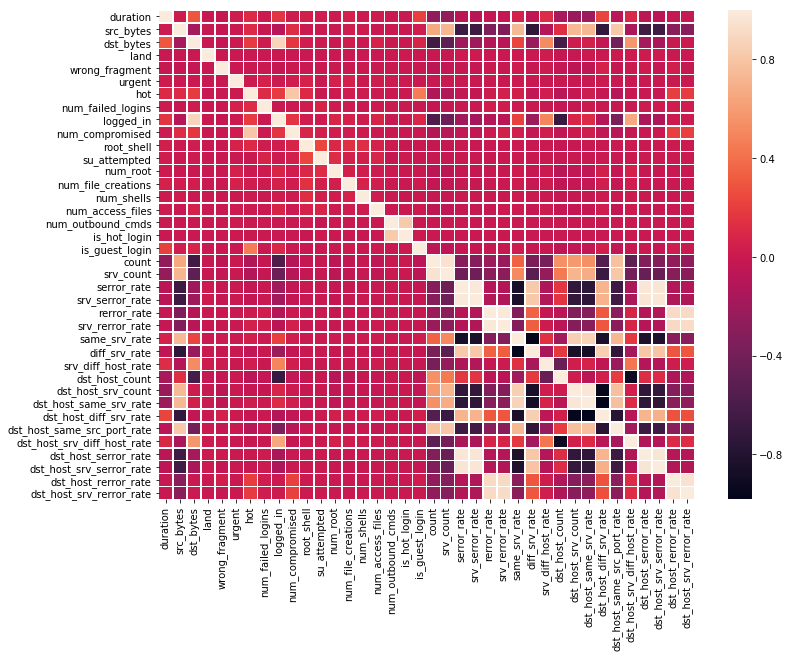

In [37]:
f,ax = plt.subplots(figsize=(12,9))
sns.heatmap(corr_df,linewidths=.5,ax=ax)
plt.show()